In [1]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow import keras


In [3]:
# Check tensorflow version
print(tf.__version__)

2.11.0


In [4]:
# Abrimos nuestros dataset para prepararlo
df_train = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/train_data.csv', sep=';', decimal='.')
print(df_train.shape)

df_test = pd.read_csv('./drive/MyDrive/deep-learning-rogelio/test_data.csv', sep=';', decimal='.')
print(df_test.shape)

(750, 22)
(250, 22)


In [5]:
# Separamos x_train, y_train y convertimos a numpy
x_train = df_train.drop('Price', axis=1).values
y_train = df_train['Price'].values

# Hacemos lo mismo con el conjunto de test
x_test = df_test.drop('Price', axis=1).values
y_test = df_test['Price'].values


In [6]:
# Normalizamos los datos
#scaler = StandardScaler()
##x_train = scaler.fit_transform(x_train)
##x_test = scaler.transform(x_test)

#scaler.fit(x_train)
# Transform the training and validation data
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [8]:
# Revisamos que no tengamos valores negativos
min_vals = np.min(x_tr, axis=0)
print('Minimum values in each column:')
for i, val in enumerate(min_vals):
    print(f'Column {i+1}: {val}')

Minimum values in each column:
Column 1: 0.0
Column 2: 0.0
Column 3: 0.0
Column 4: 0.0
Column 5: 0.0
Column 6: 0.0
Column 7: 0.0
Column 8: 0.0
Column 9: 0.0
Column 10: 0.0
Column 11: 0.0
Column 12: 0.0
Column 13: 0.0
Column 14: 0.0
Column 15: 0.0
Column 16: 0.0
Column 17: 0.0
Column 18: 0.0
Column 19: 0.0
Column 20: 0.0
Column 21: 0.0


In [11]:
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs):
  
  # Implementamos la red empleando Keras
  model = Sequential() # Instancia de modelo API secuencial #(X)
  model.add(Dense(64, activation=activation_function, name='mlp_dense_1', input_shape=(x_tr.shape[1],)))
  model.add(Dropout(0.2, name='mlp_dropout_1',))
  model.add(Dense(64, activation=activation_function, name='mlp_dense_2',))
  model.add(Dropout(0.2, name='mlp_dropout_2',))
  model.add(Dense(1, activation='linear', name='mlp_dense_3',)) 
  
  # Create the callbacks
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

  
  # Compilamos el modelo
  model.compile(
      optimizer=Adam(learning_rate=learning_rate, decay=lr_decay), 
      loss='mse', 
      metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), metrics.Accuracy()]
      ) #(X)
  # Entrenamos el modelo
  H = model.fit(x_tr, y_tr, 
                batch_size=batch_size, 
                epochs=num_epochs, 
                validation_data=(x_val, y_val), 
                callbacks=[early_stopping, reduce_lr], 
                verbose=0)
  print(H.history)

  # Evaluamos con test
  y_pred = model.predict(x_test, batch_size=batch_size)

  # Evaluate the performance of the model
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Print the evaluation metrics
  print('Mean Squared Error (MSE):', mse)
  print('Mean Absolute Error (MAE):', mae)
  print('R-squared (R^2):', r2)

  # Ploteamos para imprimir las metricas
  fig = plt.figure(figsize=(12, 10))
  gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

  for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
      row = i // 2
      col = i % 2
      ax = fig.add_subplot(gs[row, col])
      ax.plot(H.history[metric], label='Training')
      ax.plot(H.history['val_' + metric], label='Validation')
      ax.set_title(metric)
      ax.set_xlabel('Epoch')
      ax.set_ylabel(metric)
      ax.legend(loc='upper right')

  # Add a subplot to show the accuracy over time
  #ax = fig.add_subplot(gs[1, 1])
  #ax.plot(H.history['accuracy'], label='Training')
  #ax.plot(H.history['val_accuracy'], label='Validation')
  #ax.set_title('Accuracy')
  #ax.set_xlabel('Epoch')
  #ax.set_ylabel('Accuracy')
  #ax.legend(loc='upper right')
  
  # Add a horizontal line to the plot for the R2 score
  plt.axhline(y=r2, color='k', linestyle='--', label='R2 score')
  plt.suptitle('Training and Validation Metrics', fontsize=16, y=1.05)
  plt.legend(loc='lower right')
  plt.show()
  # Guardamos el modelo, este modelo usaremos en la combinacion, en la segunda parte
  model.save('model_ann_v1.h5')
  !cp -r model_ann_v1.h5 /content/drive/My\ Drive/deep-learning-rogelio/model_ann_v1.h5



Entrenando con relu, 0.001, 5e-06, 128
{'loss': [7367.2724609375, 7304.30615234375, 7228.39990234375, 7145.2919921875, 7050.3076171875, 6904.30810546875, 6722.1015625, 6471.16943359375, 6194.5556640625, 5813.6083984375, 5355.173828125, 4874.255859375, 4331.2001953125, 3841.462890625, 3354.7470703125, 2938.3974609375, 2649.567138671875, 2482.037109375, 2425.158935546875, 2395.230224609375, 2254.172119140625, 2203.11083984375, 2254.646728515625, 2119.35009765625, 2122.607177734375, 2051.92578125, 2099.245361328125, 2073.354248046875, 1970.144775390625, 2015.344970703125, 1949.1898193359375, 1901.3885498046875, 1945.473876953125, 1886.5699462890625, 1836.716796875, 1884.9588623046875, 1866.8485107421875, 1848.181884765625, 1767.28515625, 1796.203369140625, 1797.373291015625, 1696.6217041015625, 1776.7557373046875, 1638.8599853515625, 1652.638916015625, 1650.9488525390625, 1711.70068359375, 1688.293701171875, 1672.936279296875, 1627.028564453125, 1609.0029296875, 1719.1959228515625, 1583.2

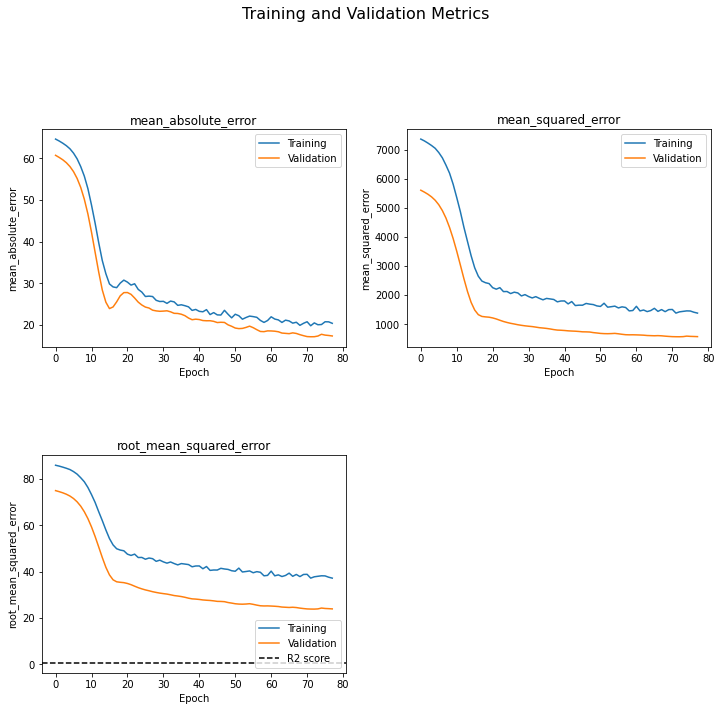

In [12]:
# Definimos los parámetros que queremos probar
activation_functions = ['relu']
learning_rates = [1e-3 ]
lr_decays = [1e-3 / 200]
batch_sizes = [128]
num_epochs = 100
# llama a la función para entrenar la red con los parámetros deseados
results = {}
for activation_function in activation_functions:
    for learning_rate in learning_rates:
        for lr_decay in lr_decays:
            for batch_size in batch_sizes:
                print(f'Entrenando con {activation_function}, {learning_rate}, {lr_decay}, {batch_size}')
                train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs)